In [1]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=467a064a6a48f8290298917634e472f86342d0ad978150ed928dcea4e7683e89
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [2]:
import os
import time
import copy
import pickle
import random
import numpy as np
import pandas as pd

import itertools
from PIL import Image
from tqdm import tqdm

from scipy.stats import entropy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
import torchvision
import torchvision.transforms as transforms
from efficientnet_pytorch import EfficientNet

from torch.utils.data import Dataset, DataLoader, Subset
random.seed(100)

In [3]:
batch_size = 16
train_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.25),
        transforms.RandomVerticalFlip(p=0.25),
        transforms.RandomAffine(degrees=20, translate=(0.25, 0.25), shear=(-0.25, 0.25)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


test_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

])

In [4]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dictt = pickle.load(fo, encoding='latin1')
    return dictt

In [5]:
# Read dictionary
data_train = unpickle("../input/cifar100/train")
data_test = unpickle("../input/cifar100/test")
data_meta = unpickle("../input/cifar100/meta")

subCategory = pd.DataFrame(data_meta['fine_label_names'], columns=['SubClass'])
subCategoryDict = subCategory.to_dict()
for key in subCategoryDict.keys():
    print(key, ": ", subCategoryDict[key])

SubClass :  {0: 'apple', 1: 'aquarium_fish', 2: 'baby', 3: 'bear', 4: 'beaver', 5: 'bed', 6: 'bee', 7: 'beetle', 8: 'bicycle', 9: 'bottle', 10: 'bowl', 11: 'boy', 12: 'bridge', 13: 'bus', 14: 'butterfly', 15: 'camel', 16: 'can', 17: 'castle', 18: 'caterpillar', 19: 'cattle', 20: 'chair', 21: 'chimpanzee', 22: 'clock', 23: 'cloud', 24: 'cockroach', 25: 'couch', 26: 'crab', 27: 'crocodile', 28: 'cup', 29: 'dinosaur', 30: 'dolphin', 31: 'elephant', 32: 'flatfish', 33: 'forest', 34: 'fox', 35: 'girl', 36: 'hamster', 37: 'house', 38: 'kangaroo', 39: 'keyboard', 40: 'lamp', 41: 'lawn_mower', 42: 'leopard', 43: 'lion', 44: 'lizard', 45: 'lobster', 46: 'man', 47: 'maple_tree', 48: 'motorcycle', 49: 'mountain', 50: 'mouse', 51: 'mushroom', 52: 'oak_tree', 53: 'orange', 54: 'orchid', 55: 'otter', 56: 'palm_tree', 57: 'pear', 58: 'pickup_truck', 59: 'pine_tree', 60: 'plain', 61: 'plate', 62: 'poppy', 63: 'porcupine', 64: 'possum', 65: 'rabbit', 66: 'raccoon', 67: 'ray', 68: 'road', 69: 'rocket', 

In [6]:
# only use 10000 labelled samples
x_train, y_train = data_train['data'][0:10000], data_train['fine_labels'][0:10000]
x_valid, y_valid = data_test['data'], data_test['fine_labels']
print(x_train.shape, x_valid.shape)
print(type(x_train), type(y_train))

(10000, 3072) (10000, 3072)
<class 'numpy.ndarray'> <class 'list'>


In [7]:
# .transpose(0,2,3,1)

x_train = x_train.reshape(len(x_train),3,32,32)
x_valid = x_valid.reshape(len(x_valid),3,32,32)

x_train, y_train = np.asarray(x_train), np.asarray(y_train)
x_valid, y_valid = np.asarray(x_valid), np.asarray(y_valid)

print(type(x_train), type(y_train), type(x_valid), type(y_valid))
print(y_train.shape, y_valid.shape)
print(np.max(y_train), np.max(y_valid))

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
(10000,) (10000,)
99 99


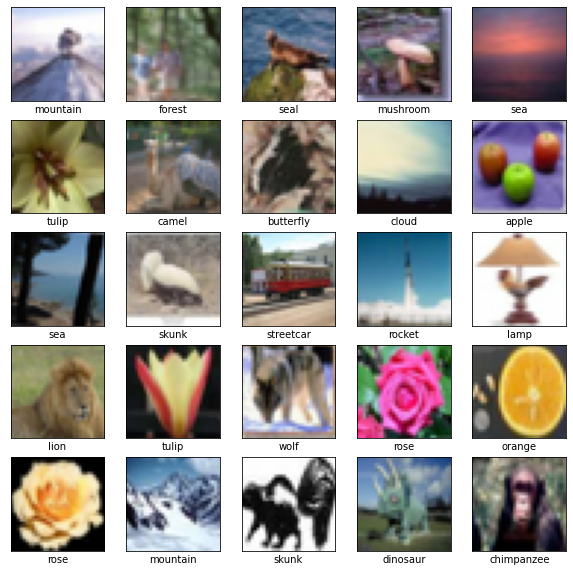

In [8]:
import matplotlib.pyplot as plt

def plot_images(X_test):
    plt.figure(figsize=(10,10))
    for image in range(0,25):
        i=image
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        j=i+0
        data_plot = X_test[j].transpose(1,2,0)
        plt.imshow(data_plot)
        plt.xlabel(str(subCategoryDict['SubClass'][y_valid[j]]))
    plt.show()
    
plot_images(x_valid)

In [9]:
class MyDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = torch.LongTensor(targets)
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        if self.transform:
            x = Image.fromarray(self.data[index].astype(np.uint8).transpose(1,2,0))
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.data)

In [10]:
train_dataset = MyDataset(x_train, y_train, transform=train_transforms)
valid_dataset = MyDataset(x_valid, y_valid, transform=test_transforms)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=4)

dataloaders = {'train': train_dataloader, 'val':valid_dataloader}
dataset_sizes = {'train': len(train_dataset), 'val':len(valid_dataset)}

print(dataset_sizes['train'], dataset_sizes['val'])
print(len(train_dataloader), len(valid_dataloader))

10000 10000
625 625


In [11]:
class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model = torchvision.models.resnet18(pretrained=True)
        self.linear = nn.Linear(in_features=512, out_features=100)
        self.base_model.fc = self.linear
        
    def forward(self, x):
        x = self.base_model(x)
        return x

In [12]:
# train all three models on this sampled_dataset 
# N is number of samples
# this subset is for ResNet

N = 8000
random_idx = random.sample(range(0, 10000), N)
sampled_dataset = Subset(train_dataset, random_idx)
sampled_dataloader = DataLoader(sampled_dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)

print(len(sampled_dataset))

8000


In [13]:
def train(model, dataloader, optimizer,criterion, dataset_size, device):
    model = model.train()
    running_loss = 0
    running_corrects = 0
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)  
    return running_loss / dataset_size, running_corrects.double() / dataset_size

In [14]:
def evaluate(model, dataloader, criterion, dataset_size, device):
    running_corrects = 0
    running_loss = 0
    model = model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)  
    return running_loss / dataset_size, running_corrects.double() / dataset_size

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_res = ResNet()
model_res.to(device)
optimizer = optim.Adam(model_res.parameters(), lr=0.0001)
scheduler = MultiStepLR(optimizer, milestones=[10], gamma=0.1)
criterion = nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [16]:
counter = 0
num_epochs = 120
best_loss_acc = 0.0
best_loss = 50000
best_model = copy.deepcopy(model_res.state_dict())
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-' * 10)
    train_epoch_loss, train_epoch_acc = train(model=model_res, dataloader=sampled_dataloader, criterion=criterion, optimizer=optimizer,dataset_size=len(sampled_dataset), device=device)
    print('Train Loss: {:.4f}, Train Acc: {:.4f}'.format(train_epoch_loss, train_epoch_acc))
    test_epoch_loss, test_epoch_acc = evaluate(model=model_res, dataloader=valid_dataloader, criterion=criterion, dataset_size=len(valid_dataset), device=device)
    print('Test Loss: {:.4f}, Test Acc: {:.4f}'.format(test_epoch_loss, test_epoch_acc))
    scheduler.step()
    if test_epoch_loss < best_loss:
        counter = 0
        best_loss = copy.deepcopy(test_epoch_loss)
        best_loss_acc = copy.deepcopy(test_epoch_acc)
        print('Best loss till now {:.4f}, saving model'.format(best_loss))
        print('valid accuracy for this loss {:.4f}, saving model'.format(best_loss_acc))
        best_model = copy.deepcopy(model_res.state_dict())
        
    else:
        counter = counter + 1
        print("value of counter right now: ", counter)
        if counter >= 5:
            break
        else:
            pass

print(best_loss_acc)
# Restoring best model
model_res.load_state_dict(best_model)

Epoch 1/120
----------
Train Loss: 4.3444, Train Acc: 0.0640
Test Loss: 3.8991, Test Acc: 0.1313
Best loss till now 3.8991, saving model
valid accuracy for this loss 0.1313, saving model
Epoch 2/120
----------
Train Loss: 3.7201, Train Acc: 0.1359
Test Loss: 3.4112, Test Acc: 0.1896
Best loss till now 3.4112, saving model
valid accuracy for this loss 0.1896, saving model
Epoch 3/120
----------
Train Loss: 3.4382, Train Acc: 0.1837
Test Loss: 3.1703, Test Acc: 0.2288
Best loss till now 3.1703, saving model
valid accuracy for this loss 0.2288, saving model
Epoch 4/120
----------
Train Loss: 3.2600, Train Acc: 0.2096
Test Loss: 2.9947, Test Acc: 0.2667
Best loss till now 2.9947, saving model
valid accuracy for this loss 0.2667, saving model
Epoch 5/120
----------
Train Loss: 3.1309, Train Acc: 0.2311
Test Loss: 2.8613, Test Acc: 0.2871
Best loss till now 2.8613, saving model
valid accuracy for this loss 0.2871, saving model
Epoch 6/120
----------
Train Loss: 2.9878, Train Acc: 0.2596
Test

<All keys matched successfully>

In [17]:
print(best_loss, best_loss_acc)

2.4366330513000487 tensor(0.3826, device='cuda:0', dtype=torch.float64)


In [18]:
torch.save(model_res.state_dict(), 'resnet_cifar100_8000_samples_scheduler.pth')

In [19]:
def calculate_mean_confidence(predictions, labels):
    """Computes Average Probability, Calibration Error and Accuracy"""
    probabilities = np.max(predictions, 1)
    acc = (labels == np.argmax(predictions, 1)).sum()
    avg_prob = np.average(probabilities)
   
    return avg_prob, avg_prob - acc / labels.shape[0], acc / labels.shape[0]

In [20]:
predictions_res = []
labels_res = []

softmax = nn.Softmax(dim=1)
with torch.no_grad():
    model_res = model_res.eval()
    for images, labels in tqdm(valid_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        output = softmax(model_res(images))
        predictions_res.append(output.cpu().numpy())
        labels_res.append(labels.cpu().numpy())
        
print(len(labels_res), len(predictions_res))
print(predictions_res[0].shape, labels_res[0].shape)

100%|██████████| 625/625 [00:09<00:00, 67.02it/s]

625 625
(16, 100) (16,)


In [21]:
predictions_res_final = predictions_res[0]
labels_res_final = labels_res[0]
for i in range(1, len(predictions_res)):
    predictions_res_final = np.concatenate((predictions_res_final, predictions_res[i]))
    labels_res_final = np.concatenate((labels_res_final, labels_res[i]))

In [22]:
conf_score, cal_err, acc = calculate_mean_confidence(predictions_res_final, labels_res_final)
print(conf_score, cal_err, acc)

0.47591615 0.09331614723205567 0.3826


In [23]:
# simple 1e-4 gives 35.32% accuracy 
# simple 1e-5 gives 36.32% accuracy